In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import utils

import matplotlib.pyplot as plt

from textblob import TextBlob

In [2]:
df = pd.read_csv('data/train_E6oV3lV.csv', encoding='latin-1')

### TEXT PROCESSING

#### NORMALIZATION AND CLEANING

In [3]:
def processTweet(tweet):
    #-- Remove HTML special entities (e.g. &amp;)
    #tweet = re.sub(r'\&\w*;', '', tweet)
    #-- Convert sdsds@username to EMAIL
    tweet = re.sub('\S+@\S*','EMAIL',tweet)
    #-- Convert @username to AT_USER
    tweet = re.sub('\b@\S*','AT_USER',tweet)
    #-- Remove tickers
    #tweet = re.sub(r'\$\w*', '', tweet)
    #-- lowercase
    tweet = tweet.lower()
    #-- Remove hyperlinks
    tweet = re.sub(r'\bhttps?:\/\/\S*', '', tweet)
    tweet = re.sub(r'\bwww.*\S*', '', tweet)
    #-- Remove hashtags
    tweet = re.sub(r'#', ' ', tweet)
    #-- remove punctuation and special characters
    tweet = re.sub(r'[^a-zA-Z0-9]', ' ', tweet)
    #-- Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    #-- Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    #-- Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    #-- Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    #tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [4]:
def processTweet(tweet):
    #-- Convert sdsds@username to _email
    tweet = re.sub('\S+@\S*','_email',tweet)
    #-- Convert @username to _user
    tweet = re.sub('\b@\S*','_user',tweet)
    #-- Convert number to _number
    tweet = re.sub(r'\b[0-9]+\b', '_number', tweet)
    #-- lowercase
    tweet = tweet.lower()
    #-- Remove hyperlinks
    tweet = re.sub(r'\bhttps?:\/\/\S*', '', tweet)
    tweet = re.sub(r'\bwww.*\S*', '', tweet)
    #-- Convert hashtags into _hashtag
    tweet = re.sub(r'#', '  _hashtag ', tweet)
    #-- remove punctuation and special characters and digits
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)
    #-- Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    #-- Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    #-- Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    return tweet

In [5]:
df['tweet_processed'] = df['tweet'].apply(processTweet)

In [9]:
df['tweet_processed'] = df['tweet_processed'].apply(lambda x: str(TextBlob(x).correct()))

In [16]:
df.to_csv('data/tweetsbytextblob.csv', index=False)

#### REMOVE STOP WORDS

In [10]:
#stop_words = stopwords.words('english')#the filtering will be done when using CountVectorizer in 2.1

In [11]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['tweet_processed'] = df['tweet_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#### LEMMATIZATION

In [12]:
from textblob import Word
df['tweet_processed'] = df['tweet_processed'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [13]:
#Create class to incorporate lemmatization 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
#lemmatizationn will occur when using CountVectorizer in 2.1

### FEATURE EXTRACTION

#### TFIDF

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [77]:
#other_stop = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
#create array with the number of each word occurence for each tweet
#cv = CountVectorizer(max_df=0.9, min_df=15, tokenizer=LemmaTokenizer(), stop_words=stop_words + other_stop)
cv = CountVectorizer(max_df=0.9, min_df=15)
word_count_vect = cv.fit_transform(df.tweet_processed.tolist())
word_count_vect.toarray()#one array per document with the number of apperanced of each word

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [78]:
#map from words to index
feature_names = cv.get_feature_names()

In [79]:
len(feature_names)

2153

In [80]:
#compute tfidf for each tweet
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vect)
tf_idf_vector = tfidf_transformer.transform(word_count_vect)
#tf_idf_vector.toarray()#one array per document with the tfidf each word

In [81]:
X = tf_idf_vector.toarray()
y = df['label']

#### Doc2Vec

In [82]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

C:\Users\ppreto\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [83]:
df.columns

Index(['id', 'label', 'tweet', 'tweet_processed'], dtype='object')

In [84]:
labeled_tweets = []
for i,t in zip(df.index,df.tweet_processed):
    labeled_tweets.append(LabeledSentence(t.split(), [str(i)]))

C:\Users\ppreto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
model_dbow = Doc2Vec(dm=0,size=100,negative=5,min_count=2,alpha=0.065,min_alpha=0.065)

C:\Users\ppreto\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [86]:
model_dbow.build_vocab([x for x in labeled_tweets])
for epoch in range(60):
    model_dbow.train(utils.shuffle([x for x in labeled_tweets]), total_examples=len(labeled_tweets), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [87]:
doc2_vecs = np.zeros((df.shape[0], 100))
j = 0
for i in df.index:
    prefix = str(i)
    doc2_vecs[i] = model_dbow.docvecs[i]
    j += 1

In [88]:
doc2_vecs.min(axis=1)

array([-0.67746383, -0.85131454, -0.60374868, ..., -0.7659356 ,
       -0.793423  , -0.47833678])

In [89]:
X = np.concatenate([tf_idf_vector.toarray(), doc2_vecs], axis=1)
y = df['label']

#### XGBoost

In [90]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, classification_report
from imblearn.over_sampling import SMOTE

In [91]:
base_weights = 1/(df.label.value_counts()/max(df.label.value_counts())).values
#base_weights[1] = base_weights[1]*1.4
weights = np.array([base_weights[0]  if x == 0 else base_weights[1] for x in df.label])

In [92]:
X.shape

(31962, 2253)

training
creating model
training model
predicting
Fold:  1
Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23776
           1       0.97      1.00      0.99      1793

   micro avg       1.00      1.00      1.00     25569
   macro avg       0.99      1.00      0.99     25569
weighted avg       1.00      1.00      1.00     25569

------------
Test report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5944
           1       0.63      0.58      0.60       449

   micro avg       0.95      0.95      0.95      6393
   macro avg       0.80      0.78      0.79      6393
weighted avg       0.94      0.95      0.95      6393



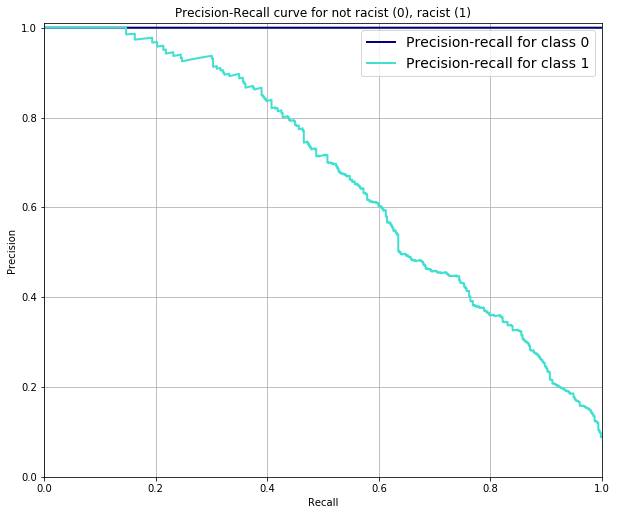




creating model
training model


KeyboardInterrupt: 

In [93]:
# create object for cross validation (5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
fold = 1

precisions = []
recalls = []

print("training")
for train_index, test_index in skf.split(X, y):
    # split data
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    weights_train = weights[train_index]
    
    """
    #sample data
    unique, counts = np.unique(y_train, return_counts=True)
    d = dict(zip(unique, counts))
    # undersample data points
    
    undersampler = RandomUnderSampler(sampling_strategy={1: d[1],
                                                         2: d[2],
                                                         3: int(round(d[3] / 2))},
                                      random_state=random_state)
    
    oversampler = SMOTE(sampling_strategy={0: d[0],
                                           1: d[0],
                                           },
                        random_state=20)
    
    #X_resampled, y_resampled = undersampler.fit_resample(X_train.fillna(-1), y_train)
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    #X_resampled[X_resampled==-1] = np.NaN
    
    #X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns.values)
    """
    # train model
    print("creating model")
    xgb_model = XGBClassifier(objective='binary:logistic',
                              n_estimators=300,
                              max_depth=10,
                              learning_rate=0.05,
                              n_jobs=-1,
                              random_state=20)
    print("training model")
    xgb_model.fit(X_train, 
                  y_train,
                  sample_weight=weights_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric=['logloss'],
                  early_stopping_rounds=30,
                  verbose=False
                  )
    
    print("predicting")
    # predict outputs
    train_predictions = xgb_model.predict(X_train)
    train_actuals = y_train
    
    predictions = xgb_model.predict(X_test)
    prediction_probs = xgb_model.predict_proba(X_test)
    actuals = y_test
    
    # get train performance metrics
    print("Fold: ", fold)
    print('Train report')
    print(classification_report(train_actuals, train_predictions)) 
    print('------------')
    
    # get performance metrics
    print('Test report')
    print(classification_report(actuals, predictions)) 
    precisions.append(precision_score(actuals, predictions, average=None))
    recalls.append(recall_score(actuals, predictions, average=None))
                 
    # precision-recall curve
    p_curve = dict()
    r_curve = dict()
    colors = ['navy', 'turquoise']
    for j in range(2):
        temp_actuals = np.copy(actuals)
        temp_actuals[temp_actuals != j] = 0
        temp_actuals[temp_actuals == j] = 1
        p_curve[j], r_curve[j], _ = precision_recall_curve(temp_actuals, prediction_probs[:, j])

    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    for i, color in zip(range(2), colors):
        l, = plt.plot(r_curve[i], p_curve[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0}'.format(i))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for not racist (0), racist (1)')
    plt.legend(lines, labels, prop=dict(size=14))
    plt.grid()
    #plt.savefig(os.path.join(OUT_DIR, 'images', 'experiment_4', 'p-r_curve_fold{f}.png'.format(f=fold)))
    plt.show()
    
    print('\n\n')
    fold += 1

#### Keras

In [120]:
from keras.models import Sequential #Sequential Models
from keras.layers import Dense, BatchNormalization, Activation, Dropout #Dense Fully Connected Layer Type
from keras.optimizers import SGD #Stochastic Gradient Descent Optimizer
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics

In [168]:
X.shape

(31962, 784)

In [173]:
def create_network(n_columns, lr=0.001):
    model = Sequential()
    
    model.add(Dense(1024, input_shape=(n_columns,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.1))
              
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(2, activation='softmax'))
        
    #stochastic gradient descent
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd)
    return model

In [174]:
base_weights = 1/(df.label.value_counts()/max(df.label.value_counts())).values
#base_weights[1] = base_weights[1]*1.4

In [175]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

f = []
#start cross validation
for train_idx, test_idx in kf.split(X, y):
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
        
    #create model
    model = create_network(x_train.shape[1], 0.05)
    for i in range(100):
        model.fit(x_train, y_train, batch_size=int(x_train.shape[0]), 
                      epochs=1, verbose=1, class_weight={0:base_weights[0],1:base_weights[1]}, 
                  validation_data=(x_test, y_test))

        y_train_pred = model.predict(x_train).argmax(axis=1)
        y_test_pred = model.predict(x_test).argmax(axis=1)
        f1s = metrics.f1_score(y_test, y_test_pred)
        f.append(f1s)
        print(f1s)
        #print("train\n",metrics.classification_report(y_train, y_train_pred))
        #print("test\n",metrics.classification_report(y_test, y_test_pred))

Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 8s 297us/step - loss: 1.7911 - val_loss: 2.4566
0.18470539072294187
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 189us/step - loss: 1.9389 - val_loss: 0.5486
0.36003861003861
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 206us/step - loss: 0.7930 - val_loss: 0.2035
0.4963350785340314
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 191us/step - loss: 0.7822 - val_loss: 0.2953
0.4662402274342572
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 194us/step - loss: 0.6225 - val_loss: 0.2720
0.4816446402349487
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 194us/step - loss: 0.5653 -

KeyboardInterrupt: 

In [176]:
def create_network(n_columns, lr=0.001):
    model = Sequential()
    
    model.add(Dense(1024, input_shape=(n_columns,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.1))
              
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(1, activation='sigmoid'))
        
    #stochastic gradient descent
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',optimizer=sgd)
    return model

In [184]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

f = []
#start cross validation
for train_idx, test_idx in kf.split(X, y):
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
        
    #create model
    model = create_network(x_train.shape[1], 0.05)
    for i in range(100):
        model.fit(x_train, y_train, batch_size=int(x_train.shape[0]), 
                      epochs=1, verbose=1, class_weight={0:base_weights[0],1:base_weights[1]}, 
                  validation_data=(x_test, y_test))

        y_train_pred = np.around(model.predict(x_train))
        y_test_pred = np.around(model.predict(x_test))
        f1s = metrics.f1_score(y_test, y_test_pred)
        f.append(f1s)
        print(f1s)
        #print("train\n",metrics.classification_report(y_train, y_train_pred))
        #print("test\n",metrics.classification_report(y_test, y_test_pred))

Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 8s 311us/step - loss: 1.5358 - val_loss: 0.8981
0.21091997008227376
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 183us/step - loss: 0.8940 - val_loss: 0.4814
0.3337868480725624
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 184us/step - loss: 0.7222 - val_loss: 0.4165
0.3738317757009346
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 189us/step - loss: 0.6603 - val_loss: 0.3833
0.4011299435028248
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 185us/step - loss: 0.6212 - val_loss: 0.3484
0.4297820823244553
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 185us/step - loss: 0.5882

0.6088709677419355
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 7s 256us/step - loss: 0.0326 - val_loss: 0.1708
0.6132264529058116
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 6s 225us/step - loss: 0.0306 - val_loss: 0.1722
0.6127744510978045
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 3930s 154ms/step - loss: 0.0288 - val_loss: 0.1736
0.6123260437375746
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 8s 298us/step - loss: 0.0271 - val_loss: 0.1750
0.6106719367588933
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 194us/step - loss: 0.0256 - val_loss: 0.1762
0.6094674556213018
Train on 25569 samples, validate on 6393 samples
Epoch 1/1
25569/25569 [==============================] - 5s 190u

KeyboardInterrupt: 

In [182]:
np.around(model.predict(x_test))

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)